In [1]:
# karpathy ser 🫡🫡
# part 1 here https://www.youtube.com/watch?v=PaCmpygFfXo

In [2]:
# makemore just makes more of things that you give it (lmao)

# data (kbbi)

In [3]:
# use this cool kbbi dataset
# apparently reverse engineered from a decompiled kbbi apk
url = 'https://raw.githubusercontent.com/damzaky/kumpulan-kata-bahasa-indonesia-KBBI/master/list_1.0.0.txt'
filename = 'kbbi.txt'
!wget {url} -O {filename}

--2024-06-21 00:26:00--  https://raw.githubusercontent.com/damzaky/kumpulan-kata-bahasa-indonesia-KBBI/master/list_1.0.0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285437 (1.2M) [text/plain]
Saving to: ‘kbbi.txt’

kbbi.txt            100%[===================>]   1.23M  --.-KB/s    in 0.06s   

2024-06-21 00:26:00 (19.5 MB/s) - ‘kbbi.txt’ saved [1285437/1285437]



In [4]:
import re
import random

with open(filename, 'r') as file:
  content = file.read()

pattern = r'([a-zA-Z]{5,})' # >= 5 char words
# pattern = r'(\w{5,})'
# pattern = r'([?\w-]+)'
# pattern = r'([?\w]+)'
words = re.findall(pattern, content)
words = list(set(words))
# len(words) # 71392 >= 5 char words

# if want to filter out non english chars
# import unicodedata
# # unicode_words = [unicodedata.normalize('NFKD', word) for word in words]
# for word in words:
#   uni_word = ''.join([char for char in unicodedata.normalize('NFD', word) if not unicodedata.combining(char)])
#   if uni_word != word:
#     print(uni_word, word)

# random sample
# some fun stuff https://stackoverflow.com/questions/5012560/how-to-query-seed-used-by-random-random
# random.seed()
random.sample(words, 5)

['penggilasan', 'sinsepalus', 'trilyun', 'menikai', 'menghanguskan']

a lot of structures here to model in the words, eg. 'keserimpet', we know that from this example, after 'k', 'e' is likely to come, and after 'ke', 's' is likely to come etc


# bigram

start with building a bigram model.

bigram works two chars at a time. so we see the first char that we're given, and based on that try to predict the next char after that.
(so would unigram just be an unconditional probability dist over char, and you sample from that??).

so we're modelling this local structure of chars inside words (wor(l)d-modelling lmao).


## using \<S\> and \<E\> as special tokens

In [5]:
# bigram

# the simplest way of doing bigram is to just create an
# unconditional probability dist over all bigrams and sample from them (like unigram??)
# so create a dict to store all the bigrams and count them
b = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] # create a start and end token to mark word boundaries 'hallucinate' - karpathy
  for ch1, ch2 in zip(chs, chs[1:]): # 'pretty cute' - karpathy hahaha
    # print(ch1, ch2)
    bigram = (ch1, ch2) # bigram tuple
    b[bigram] = b.get(bigram, 0) + 1

# fun
# b
# b.items()
# sorted(b.items(), key=lambda item: item[1], reverse=True)
# len(b) # 662 bigrams out of the possible ~28^2 = 784

In [6]:
# a better representation is a 2d array
# using torch.tensor
import torch

# find out all the possible chars here
# len(set(''.join(words))) # 26 chars a-z
chars = sorted(list(set(''.join(words))))
chars += ['<S>', '<E>']

# make this into a dic that maps char into col/row num
ch_to_i = {char: i for i, char in enumerate(chars)}
i_to_ch = {i: char for char, i in ch_to_i.items()}

# make a zero tensor with length 26 (unique char in words) + 2 (the start and end token)
N = torch.zeros([len(chars), len(chars)], dtype=torch.int32)

# using the same logic as before
for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = ch_to_i[ch1]
    idx2 = ch_to_i[ch2]
    N[idx1, idx2] += 1

# N

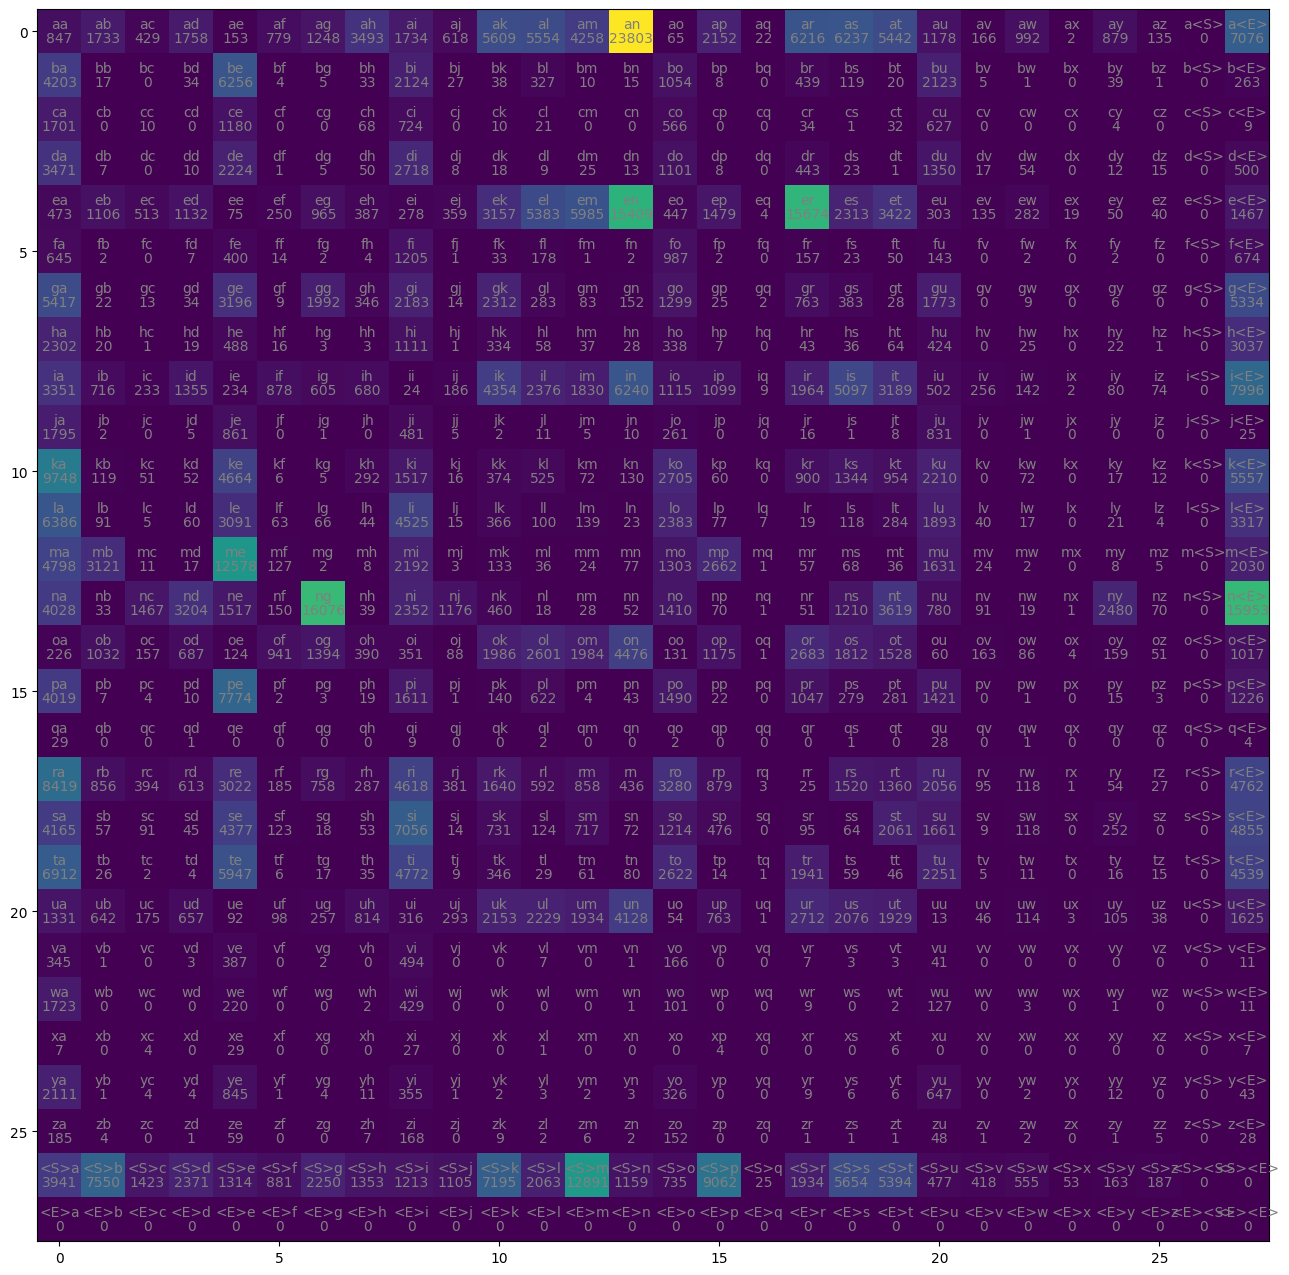

In [7]:
# we can visualize this 2d array beautifully like so
# using karpathy's code
# rly good tbh
# such a good way of truly looking at the probability space so good
import matplotlib.pyplot as plt

plt.figure(figsize=(16,16))
plt.imshow(N)
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    chstr = i_to_ch[i] + i_to_ch[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
    # plt.text(j, i) because the convention here is that col_num (x coord) first then row_num (y coord), like we do in cartesian system
# plt.axis('off')
plt.savefig('tensor-viz') # defaults png

## using a single token for start and end

In [8]:
import torch

chars = sorted(list(set(''.join(words))))
chars = ['.'] + chars # a bit different implementation than karpathys

# make this into a dic that maps char into col/row num
ch_to_i = {char: i for i, char in enumerate(chars)}
i_to_ch = {i: char for char, i in ch_to_i.items()}

# make a zero tensor with length 27
N = torch.zeros([len(chars), len(chars)], dtype=torch.int32)

# using the same logic as before
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    idx1 = ch_to_i[ch1]
    idx2 = ch_to_i[ch2]
    N[idx1, idx2] += 1

# N

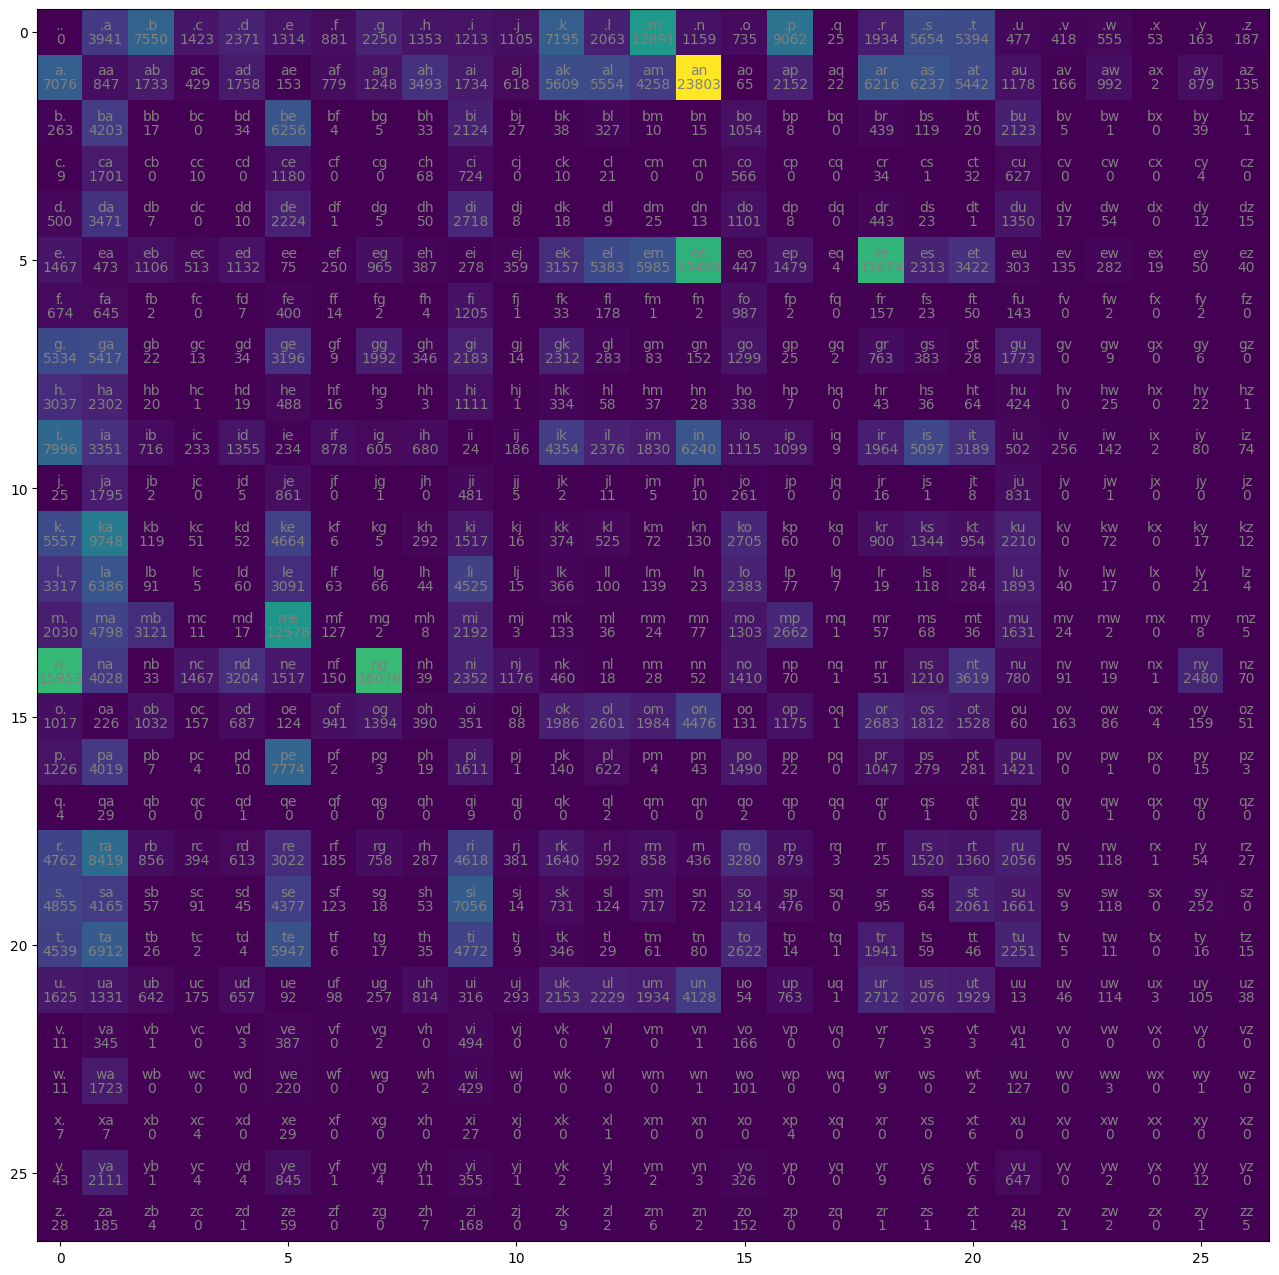

In [9]:
# we can visualize this 2d array beautifully like so
# using karpathy's code
# rly good tbh
# such a good way of truly looking at the probability space so good
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.figure(figsize=(16,16))
plt.imshow(N)
# plt.imshow(N, norm=LogNorm()) using log scale
for i in range(N.shape[0]):
  for j in range(N.shape[1]):
    chstr = i_to_ch[i] + i_to_ch[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i,j].item(), ha='center', va='top', color='gray')
    # plt.text(j, i) because the convention here is that col_num (x coord) first then row_num (y coord), like we do in cartesian system
# plt.axis('off')
plt.savefig('tensor-viz') # defaults png

## sampling

In [40]:
# let's try sampling from this
g = torch.Generator().manual_seed(6009)
# g = torch.Generator() # initial_seed seems to be always 67280421310721, one of the prime factors of the sixth fermat number haha

# make this more efficient by not repeating the p = p / p.sum() calculation
# create a normalized-by-row tensor
P = N.float() # turn the datatype from int to float
P /= P.sum(1, keepdim=True) # be very very mindful of broadcasting rules
# P is shaped [27, 27]; P.shape(1) means summing along the 1st dim; ie. summing along the cols
# which means P.sum(1, keepdim=True) will be shaped [27, 1]
# Now, in P /= P.sum(1, keepdim=True), we'll have to kepe in mind pytorch's broadcasting semantics/rules (https://pytorch.org/docs/stable/notes/broadcasting.html)
# when you divide P (shaped [27,27]) with P.sum(1, keepdim=True) (shaped[27,1]),
# you broadcast the smaller dim in the smaller tensor to the larger dim of the larger tensor
# one way to think of it is that we replicate the col of P.sum to 27 copies of cols
# then do the division element-wise
# karpathy said that broadcasting bugs are one of the most subtle and hardest to debug

# so really P is just a tensor of parameters of our bigram model


for i in range(10):
  idx = 0 # notice if you change this idx, it would not change the generation of chars afterwards because it's determined by the gen that we have
  # print(i_to_ch[idx])
  temp = [i_to_ch[idx]] # store chars
  # print(g.get_state().sum()) use torch_equal to see that the state really changes each iter lmao
  while True:
    # sample new idx
    # # more efficient
    p = P[idx, :]
    # # inefficient
    # p = N[idx, :].float() # turn it into float
    # p = p / p.sum() # normalize it
    # # if p is a uniform dist over the chars
    # p = torch.ones(N.shape[1]) / N.shape[1]
    # # sampling here
    idx = torch.multinomial(p, 1, replacement=True, generator=g).item()
    # idx = torch.multinomial(p, 1, replacement=True).item() # without generator (will be different eact hime)

    # convert idx to ch
    # print(i_to_ch[idx])
    temp.append(i_to_ch[idx])

    # if . then halt
    if idx == 0:
      break
  print(''.join(temp))
  # the outputs are kinda cool tbh

.perutidi.
.h.
.keh.
.meung.
.sun.
.tokenimbak.
.kanal.
.pengs.
.r.
.k.


so now we've trained a bigram a language model. and by *training* we mean *counting* all the occurences of bigrams in kamus-besar-bahasa-indonesia, then *normalizing* the occurences to make a nice probability distribution over chars given the first char to ourselves. (btw torch.multinomial() doesn't require that our tensor to sum to 1, only that it's nonegative, finite, and have a nonzero sum; meaning it'll normalize the tensor by itself)

\(isn't this essentially just a markov model??\)

we observe that the model is terrible; but *is a huge improvement* over the prior of uniform distribution of chars (try it yourself).

we can notice that we *don't* actually learn bahasa indonesia (or languages in general) by modelling what char is likely to come after given a char before that (at least not by *just* that). so, we see that the choice of just modelling the bigrams of kbbi loses out so much structure present in the lexicon of bahasa indonesia.  

## evaluate the quality of this model

we want to somehow summarize the quality of this model to a single number, by quality we mean how good is this model at predicting the set we test it on (in this case, just the training set)

# coretan (scratchpad)

## len of indo words

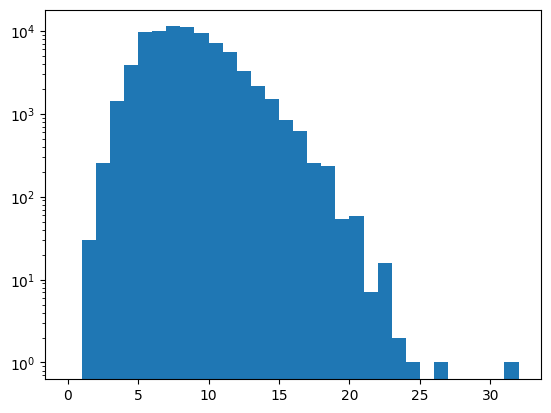

In [ ]:
# words
import re
import random

with open(filename, 'r') as file:
  content = file.read()

# pattern = r'(\w{5,})' # >= 5 char words
pattern = r'([?\w-]+)'
# pattern = r'([?\w]+)'
words = re.findall(pattern, content)
words = list(set(words))


# fun stuff
# min(len(word) for word in words)
# max(len(word) for word in words)
# sorted(words, key=len, reverse=True)[:50]
# sorted(words, key=len)[:50]

# histogram
import matplotlib.pyplot as plt

length = [len(word) for word in words]
plt.hist(length, bins=range(0, max(length)+2))
plt.yscale('log')
plt.show()

## trying out regex

In [ ]:
import re

with open(filename, 'r') as file:
  content = file.read()

# we can use the usual python stuff
words = content.split()
# regex over word in words
pattern = re.compile(r'([\w]+)')
words = [pattern.search(word).group(1) for word in words if pattern.search(word)] # only takes the first match
words = list(set(words)) # make it unique
# # words = [word for word in words if len(word)>=5]
# len(words)


# or use a cool regex method
pattern = r'([\w]+)'
words2 = re.findall(pattern, content) # some weird stuff in the dataset makes some unicode characters registered as ?
words2 = list(set(words2))
# len(words2)

77131

In [ ]:
# Convert lists to sets
set1 = set(words)
set2 = set(words2)

# Find elements in list1 that are not in list2
diff1 = set1 - set2

# Find elements in list2 that are not in list1
diff2 = set2 - set1

# diff1
# diff2

## trying out sed and awk and unix commands lmao

In [ ]:
# !cat kbbi.txt
# use head or tail
# !tail -n 10 kbbi.txt

# or use sed or awk
# to see rand_int use this
import random, subprocess
num_lines = int(subprocess.check_output(['wc', '-l', '/content/kbbi.txt']).split()[0])
range = 10
floor = random.randint(0, num_lines-1 - 9)
ceil = floor + 9
# awk_command = f"NR>={floor} & NR<={ceil}"
# !awk {awk_command} '/content/kbbi.txt'
sed_command = f"{floor},{ceil}p"
!sed -n {sed_command} kbbi.txt
# sed_command

tangan kanan jangan percaya akan tangan kiri
tangan kemudi
tangan kosong
tangan kotor
tangan mencencang, bahu memikul
tangan mencencang (memetik, menetak) bahu memikul
tangan menetak (mencencang), bahu memikul
tangan menggenggam tangan
tangan naik
tangan panas
